In [1]:
# Must restart the kernel for this
from deepexplain.tensorflow import DeepExplain
#from deeplift.dinuc_shuffle import dinuc_shuffle, traverse_edges, shuffle_edges, prepare_edges
import modisco
from collections import Counter

from importlib import reload
import re
import random
from pathlib import Path
random.seed(1337)
import os
import pickle
from decimal import Decimal

import numpy as np
np.random.seed(1337)
import pandas as pd
pd.options.mode.chained_assignment = None 
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib_config
import seaborn as sns

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

import utils_data
import model

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


In [2]:
from bpnet.cli.contrib import ContribFile
from bpnet.plot.tracks import plot_tracks, to_neg
from concise.utils.plot import seqlogo

Instructions for updating:
Colocations handled automatically by placer.


2021-02-02 13:35:22,204 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [3]:
def plot_logo(arr, name="", fig_dims = (6.0, 1.5)):
    fig,ax = plt.subplots()
    seqlogo(arr, vocab="RNA", ax=ax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_ylim(-1.75, 1.75)
    #ax.set_ylabel("")
    #ax.tick_params(axis='both', which='major', labelsize=10)

    sns.despine(fig, bottom=True, left=True)
    fig.set_size_inches(fig_dims)
    #fig.savefig(Path("../Graphics/motifs/" + name +".svg"))

## Actual contributions

In [4]:
def explain_deeply(encoded_df, batchsize=64):
    K.clear_session()
    sess = K.get_session()
    with DeepExplain(session=sess) as de:
        utr_model = load_model("../Models/utr_model_50.h5", 
                   custom_objects={'FrameSliceLayer': model.FrameSliceLayer})
        input_tensor = utr_model.layers[0].input
        target_tensor = utr_model(input_tensor)
        return de.explain('grad*input', target_tensor, input_tensor, encoded_df, batch_size=batchsize)

In [5]:
# get input sequences
one_hot = utils_data.OneHotEncoder("utr")
with open(Path("../Data/data_dict.pkl"), 'rb') as handle:
    data_dict = pickle.load(handle)
mpra_data = data_dict["mpra"]
train_data = mpra_data[(mpra_data.set == "train") & (mpra_data.library == "egfp_unmod_1")]
encoded_mpra = one_hot(train_data)

In [6]:
attrib = explain_deeply(encoded_mpra)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2021-02-02 13:35:35,042 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


2021-02-02 13:35:40,275 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


2021-02-02 13:35:40,419 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
2021-02-02 13:35:41,701 [INFO] DeepExplain: running "grad*input" explanation method (2)
2021-02-02 13:35:41,712 [INFO] Model with multiple inputs: False


In [34]:
np.save("../Data/Contributions/attrib.npy", attrib)

## Hypothetical contributions

In [7]:
utr_model = load_model("../Models/utr_model_50.h5", 
                   custom_objects={'FrameSliceLayer': model.FrameSliceLayer})
input_tensor = utr_model.layers[0].input
target_tensor = utr_model(input_tensor)

In [8]:
fn = K.function([input_tensor], K.gradients(target_tensor, input_tensor))

In [9]:
grad_list = []
for i in range(32):
    grad_list.append(fn([encoded_mpra[(7500*i):(7500*(i+1))]])[0])

In [10]:
grad = np.concatenate(grad_list,axis=0)

In [61]:
np.save("../Data/Contributions/grad.npy", grad)

In [62]:
grad_top = grad[val_data["rl"] > 8.5]
grad_min = grad[val_data["rl"] < 3]
grad_nonaug_low = grad[(~val_data["utr"].str.contains("ATG")) & (val_data["rl"] < 7) & (val_data["rl"] > 6)]
grad_aug_high = grad[(val_data["utr"].str.contains("ATG")) & (val_data["rl"] > 8)]

In [ ]:
for i in range(10):
    plot_logo(grad_top[i], name="contrib_top" + str(i))
for i in range(10):
    plot_logo(grad_min[i], name="contrib_min" + str(i))

# **Modisco**

In [11]:
task_to_scores = {}
task_to_hyp_scores = {}
task_to_scores["mrl"] = attrib
task_to_hyp_scores["mrl"] = grad
onehot_data = encoded_mpra

MEMORY 4.127264768
On task mrl
Computing windowed sums on original
Generating null dist
peak(mu)= 0.17152756053209306
Computing threshold
Thresholds from null dist were -4.132285952568054  and  5.9376983642578125
Final raw thresholds are -4.132285952568054  and  5.9376983642578125
Final transformed thresholds are -0.9423265243902439  and  0.9761645325203252


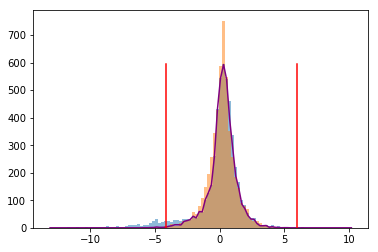

Got 68323 coords
After resolving overlaps, got 68323 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9423264243902439
MEMORY 4.469891072
68323 identified in total
min_metacluster_size_frac * len(seqlets) = 683 is more than min_metacluster_size=100.
Using it as a new min_metacluster_size
2 activity patterns with support >= 683 out of 3 possible patterns
Metacluster sizes:  [65612, 2711]
Idx to activities:  {0: '-1', 1: '1'}
MEMORY 4.47023104
On metacluster 1
Metacluster size 2711
Relevant tasks:  ('mrl',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 2711
(Round 1) Computing coarse affmat
MEMORY 4.470239232
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.62 s
Starting affinity matrix computations
Normalization computed in 0.03 s
Cosine similarity mat computed in 0.15 s
Normalization computed in 0.02 s
Cosine similarity mat computed in 0.13 s
Finished affinity matrix computations 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  43 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 193 out of 200 | elapsed:   12.0s remaining:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   12.1s finished


Louvain completed 200 runs in 15.731730461120605 seconds
Wrote graph to binary file in 7.764196872711182 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.732037
After 5 runs, maximum modularity is Q = 0.736944
After 55 runs, maximum modularity is Q = 0.736951
Louvain completed 105 runs in 33.44506812095642 seconds
Preproc + Louvain took 58.020206451416016 s
Got 16 clusters after round 1
Counts:
{11: 99, 10: 99, 5: 205, 14: 33, 2: 238, 4: 223, 12: 96, 7: 161, 9: 113, 13: 35, 0: 268, 1: 248, 3: 225, 8: 149, 6: 167, 15: 22}
MEMORY 4.625006592
(Round 1) Aggregating seqlets in each cluster
MEMORY 4.625006592
Aggregating for cluster 0 with 268 seqlets
MEMORY 4.625006592
Trimmed 14 out of 268
Skipped 144 seqlets
Aggregating for cluster 1 with 248 seqlets
MEMORY 4.625014784
Trimmed 13 out of 248
Skipped 91 seqlets
Aggregating for cluster 2 with 238 seqlets
MEMORY 4.625014784
Trimmed 16 out of 238
Skipped 94 seqlets
Aggregating for cluster 3 with 225 seq

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.1s finished


Louvain completed 200 runs in 3.9821977615356445 seconds
Wrote graph to binary file in 0.7120115756988525 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.796869
After 6 runs, maximum modularity is Q = 0.800053
After 12 runs, maximum modularity is Q = 0.800262
Louvain completed 62 runs in 12.992818355560303 seconds
Preproc + Louvain took 18.255983114242554 s
Got 17 clusters after round 2
Counts:
{2: 113, 11: 30, 7: 51, 12: 29, 15: 17, 13: 22, 9: 36, 0: 142, 14: 20, 16: 12, 1: 135, 4: 93, 8: 39, 5: 85, 10: 33, 6: 61, 3: 108}
MEMORY 4.550406144
(Round 2) Aggregating seqlets in each cluster
MEMORY 4.550406144
Aggregating for cluster 0 with 142 seqlets
MEMORY 4.550406144
Trimmed 10 out of 142
Skipped 57 seqlets
Aggregating for cluster 1 with 135 seqlets
MEMORY 4.550406144
Trimmed 9 out of 135
Skipped 18 seqlets
Aggregating for cluster 2 with 113 seqlets
MEMORY 4.550406144
Trimmed 2 out of 113
Skipped 20 seqlets
Aggregating for cluster 3 with 108 seq

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   19.7s finished


Louvain completed 200 runs in 100.52580094337463 seconds
Wrote graph to binary file in 80.94037556648254 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.87656
After 40 runs, maximum modularity is Q = 0.876562
Louvain completed 90 runs in 124.61378479003906 seconds
Preproc + Louvain took 318.7917811870575 s
Got 20 clusters after round 1
Counts:
{12: 517, 2: 948, 0: 1089, 7: 743, 8: 735, 1: 981, 6: 782, 4: 851, 15: 495, 14: 509, 19: 153, 9: 669, 16: 355, 3: 858, 5: 787, 10: 653, 17: 292, 11: 524, 13: 515, 18: 165}
MEMORY 9.229144064
(Round 1) Aggregating seqlets in each cluster
MEMORY 9.229144064
Aggregating for cluster 0 with 1089 seqlets
MEMORY 9.229144064
Trimmed 34 out of 1089
Skipped 692 seqlets
Aggregating for cluster 1 with 981 seqlets
MEMORY 9.230450688
Trimmed 37 out of 981
Skipped 621 seqlets
Aggregating for cluster 2 with 948 seqlets
MEMORY 9.231081472
Trimmed 24 out of 948
Skipped 611 seqlets
Aggregating for cluster 3 with 858 seqlets

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   15.4s finished


Louvain completed 200 runs in 27.061529397964478 seconds
Wrote graph to binary file in 22.027124404907227 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.737335
After 2 runs, maximum modularity is Q = 0.737401
After 8 runs, maximum modularity is Q = 0.741801
After 10 runs, maximum modularity is Q = 0.747894
After 18 runs, maximum modularity is Q = 0.756561
After 32 runs, maximum modularity is Q = 0.764452
Louvain completed 82 runs in 51.57136392593384 seconds
Preproc + Louvain took 103.17360806465149 s
Got 16 clusters after round 2
Counts:
{3: 450, 7: 250, 5: 313, 0: 732, 4: 344, 1: 612, 9: 223, 11: 157, 6: 264, 2: 498, 15: 37, 10: 222, 13: 80, 8: 229, 12: 83, 14: 45}
MEMORY 7.560568832
(Round 2) Aggregating seqlets in each cluster
MEMORY 7.560568832
Aggregating for cluster 0 with 732 seqlets
MEMORY 7.560568832
Trimmed 18 out of 732
Skipped 87 seqlets
Aggregating for cluster 1 with 612 seqlets
MEMORY 7.562268672
Trimmed 1 out of 612
Skipped 43 

In [13]:
null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    sliding_window_size=10,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                 task_names=["mrl"],
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 null_per_pos_scores = null_per_pos_scores)

In [14]:
import h5py
import modisco.util
grp = h5py.File("../Data/Contributions/results.hdf5", "w")
tfmodisco_results.save_hdf5(grp)
grp.close()

Metaclusters heatmap


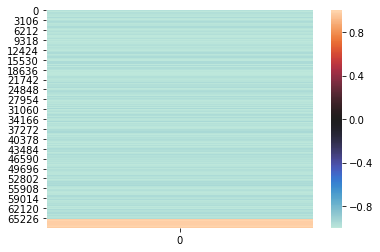

metacluster_0
activity pattern: [-1]
metacluster_0 pattern_0
total seqlets: 1655
MRL hypothetical scores:


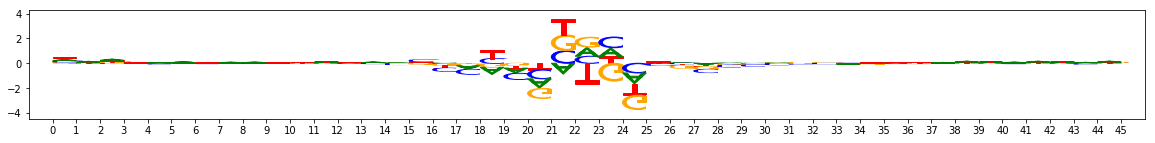

MRL actual importance scores:


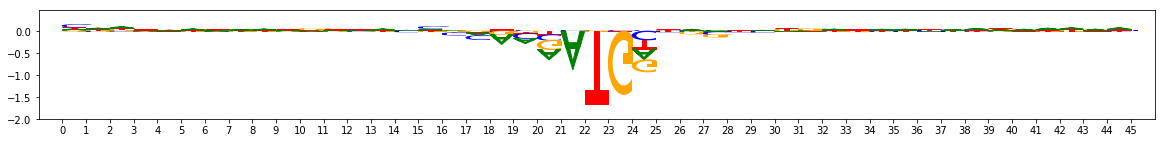

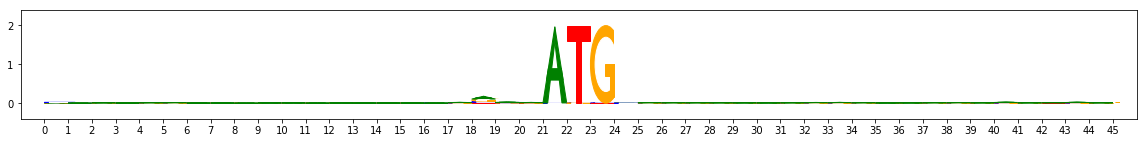

metacluster_0 pattern_1
total seqlets: 55
MRL hypothetical scores:


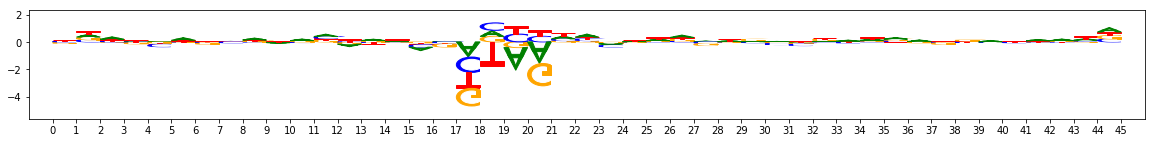

MRL actual importance scores:


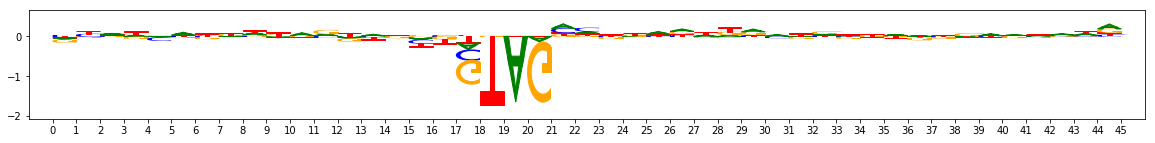

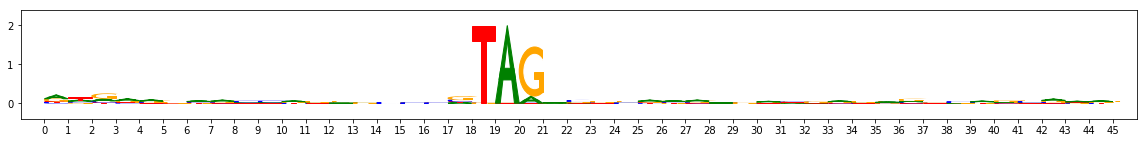

metacluster_0 pattern_2
total seqlets: 53
MRL hypothetical scores:


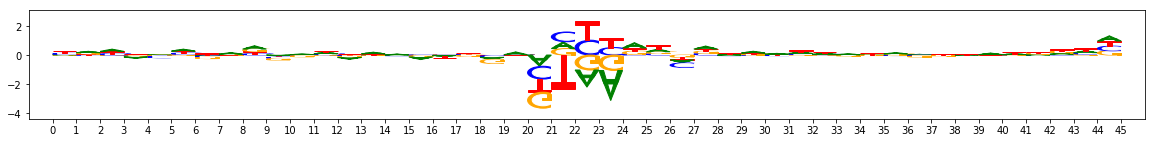

MRL actual importance scores:


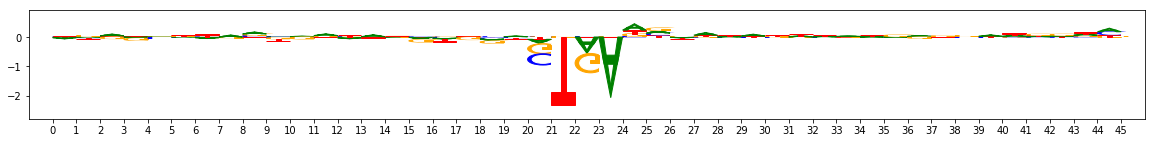

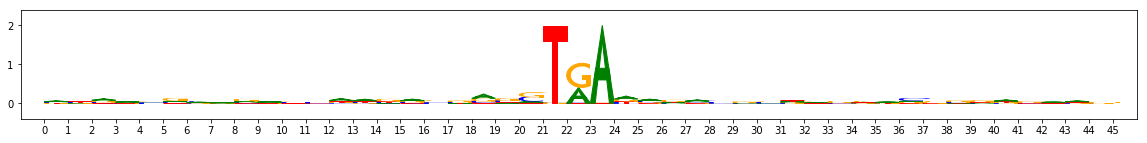

metacluster_1
activity pattern: [1]
metacluster_1 pattern_0
total seqlets: 56
MRL hypothetical scores:


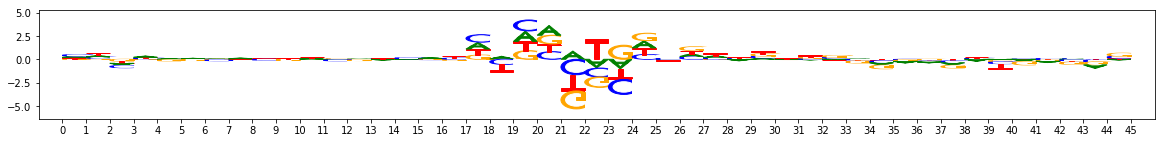

MRL actual importance scores:


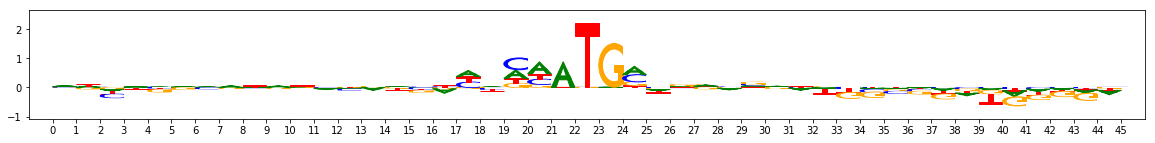

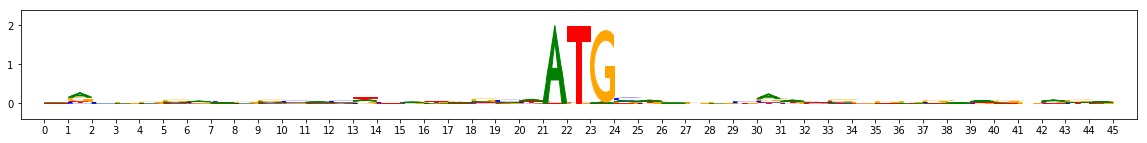

metacluster_1 pattern_1
total seqlets: 93
MRL hypothetical scores:


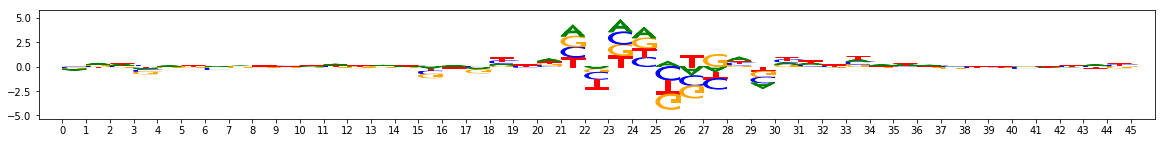

MRL actual importance scores:


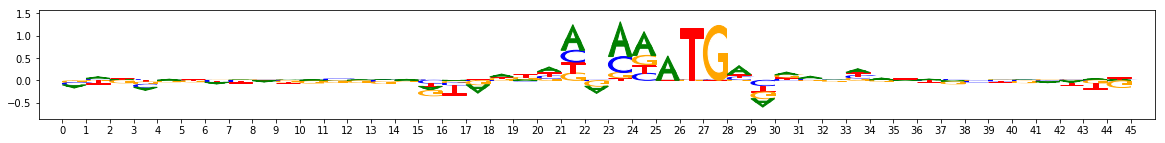

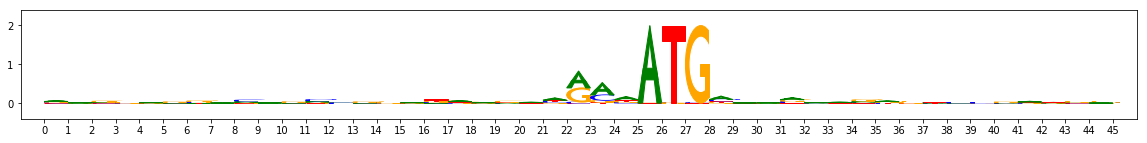

In [15]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("../Data/Contributions/results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.array([0.27, 0.23, 0.23, 0.27])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("MRL hypothetical scores:")
        viz_sequence.plot_weights(pattern["mrl_hypothetical_contribs"]["fwd"])
        print("MRL actual importance scores:")
        viz_sequence.plot_weights(pattern["mrl_contrib_scores"]["fwd"])
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        
hdf5_results.close()

Metaclusters heatmap
metacluster_0
activity pattern: [-1]
metacluster_0 pattern_0
total seqlets: 1655
metacluster_0 pattern_1
total seqlets: 55
metacluster_0 pattern_2
total seqlets: 53
metacluster_1
activity pattern: [1]
metacluster_1 pattern_0
total seqlets: 56
metacluster_1 pattern_1
total seqlets: 93


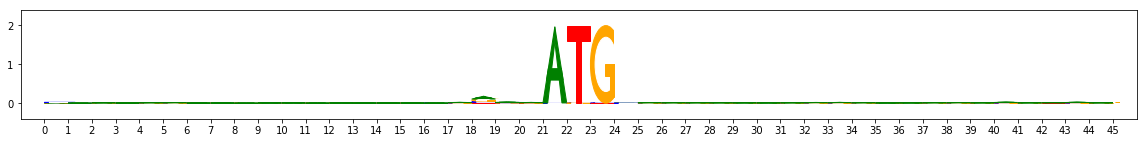

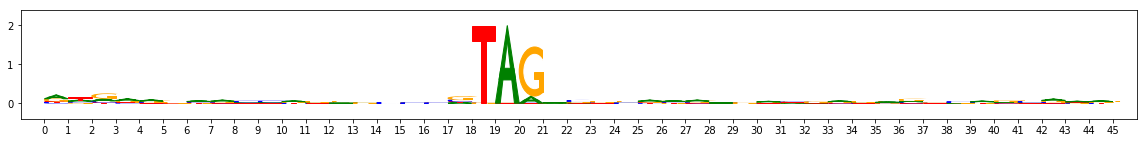

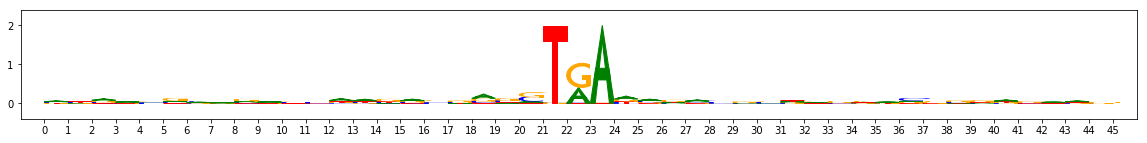

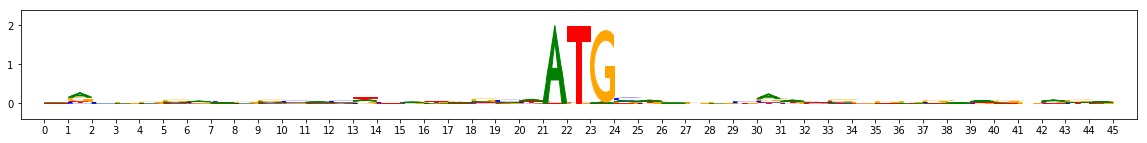

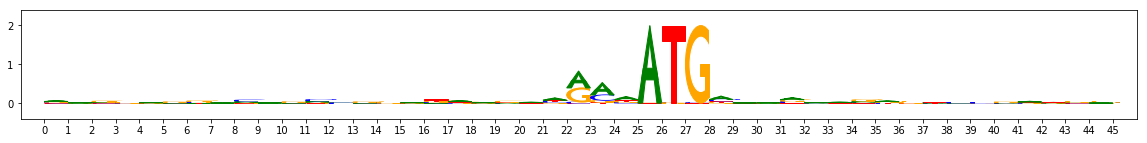

In [13]:
from importlib import reload
from collections import Counter
from modisco.visualization import viz_sequence
from matplotlib import pyplot as plt
import h5py
import numpy as np
import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("../Data/Contributions/results.hdf5","r")

def plot_weights(array,
                 figsize=(20,2),
                 **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    viz_sequence.plot_weights_given_ax(ax=ax, array=array,
                                       height_padding_factor=0.2,
                                       length_padding=1.0,
                                       subticks_frequency=1.0,
                                       highlight={})
    return fig

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.array([0.27, 0.23, 0.23, 0.27])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        fig = plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background))
        fig.savefig("../Graphics/Motifs/" + "random_" + metacluster_name + pattern_name +".svg")
        
hdf5_results.close()